In [2]:
import numpy as np
import imageio
import cv2
import matplotlib.pyplot as plt
import glob
import skimage
import scipy
from skimage.filters import (threshold_otsu, threshold_niblack,
                             threshold_sauvola)
from skimage import morphology

# BEE DETECT

In [71]:
# Load all images from TRAIN
train_imgs = np.array([np.array(imageio.imread(filename)) for filename in sorted(glob.glob('../TRAIN/*.jpg'))])

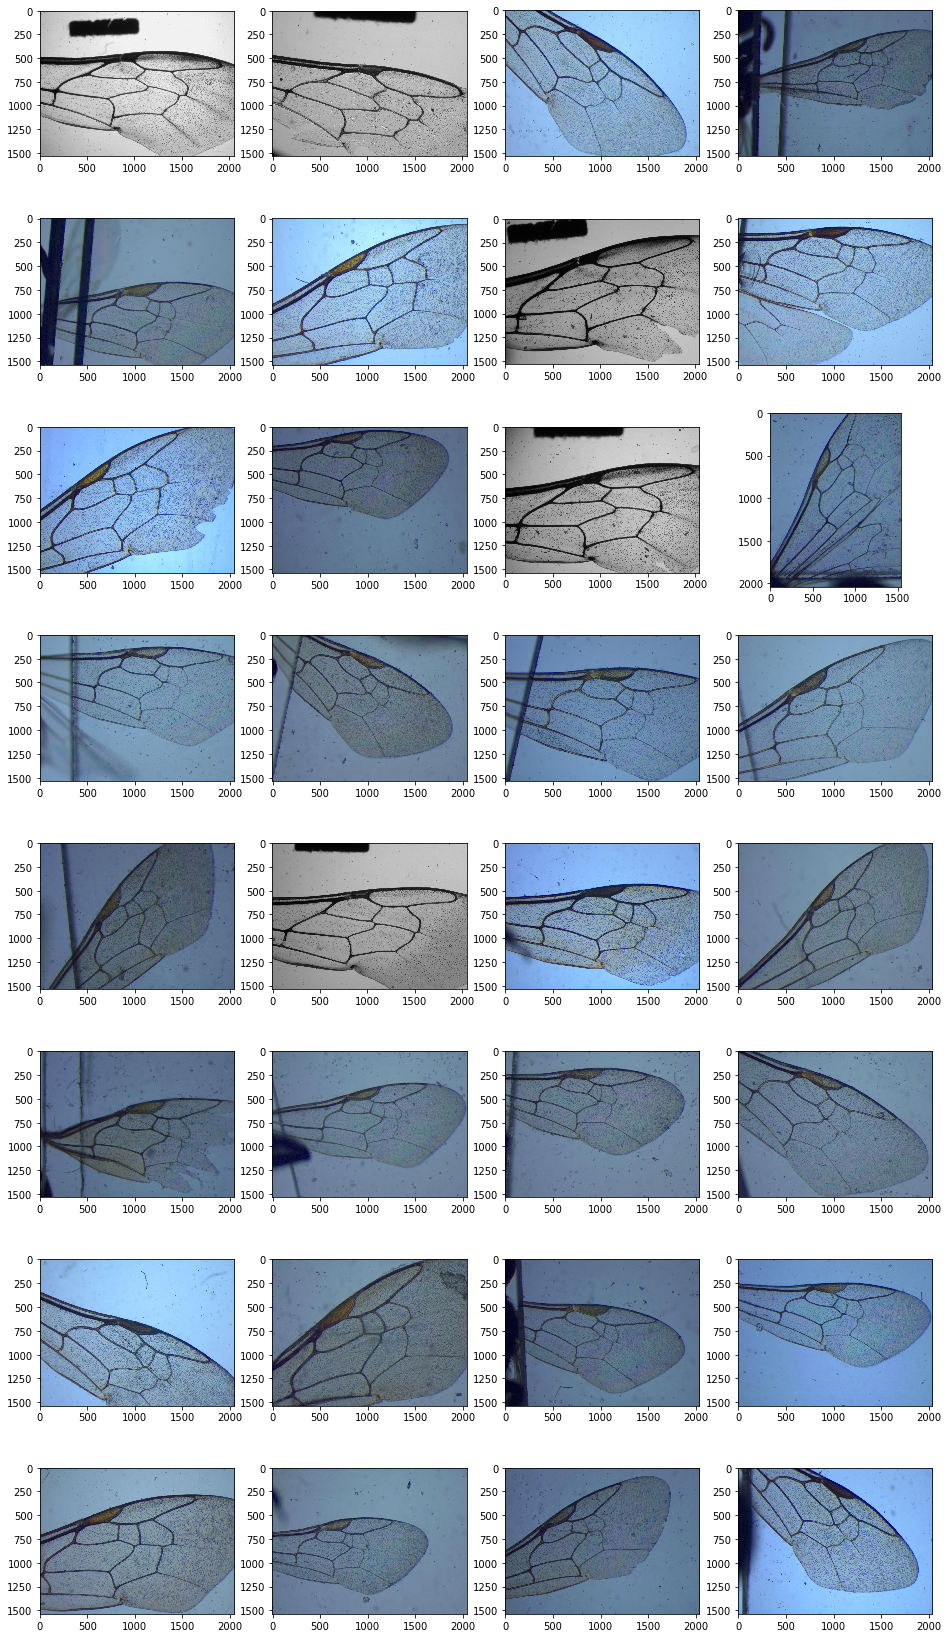

In [72]:
# Print all images from TRAIN
fig=plt.figure(figsize=(16, 30))
for i, img in enumerate(train_imgs):
    fig.add_subplot(8, 4, i+1)
    plt.imshow(img)
plt.show()

In [79]:
# Load one image and CSV from TEST
test_img = imageio.imread('../TEST/01_inf.jpg')
test_points = np.genfromtxt('../TEST/01_inf.csv', delimiter=',')

In [80]:
# Draw points from CSV on the image
def draw_points(img, points):
    img_copy = img.copy()
    for point in points:
        cv2.circle(img_copy,(int(point[1]), int(point[0])), 20, (255,255,0), -1)
    return img_copy

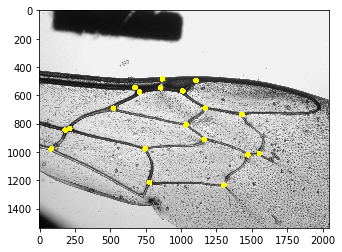

In [81]:
plt.imshow(draw_points(test_img, test_points))

# Results

In [82]:
def process(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    threshold_val = threshold_sauvola(gray, window_size=159)
    bin_img = (gray > threshold_val).astype(np.uint8)
    kernel = np.ones((5,5), np.uint8)
    blur = cv2.bilateralFilter(bin_img, 14, 75, 75)
    inv = np.invert(blur)
    img_dilate = cv2.dilate(inv, kernel, iterations=10)
    img_erode = cv2.erode(img_dilate, kernel, iterations=7)
    inv_img = np.invert(img_erode)
    all_labels = skimage.measure.label(1 - skimage.morphology.remove_small_objects((1 - inv_img).astype(bool),min_size=5000))
    kernel = np.ones((5,5), np.uint8)
    img_dilate = cv2.dilate(all_labels.astype(np.uint8), kernel, iterations=6) 
    return img_dilate

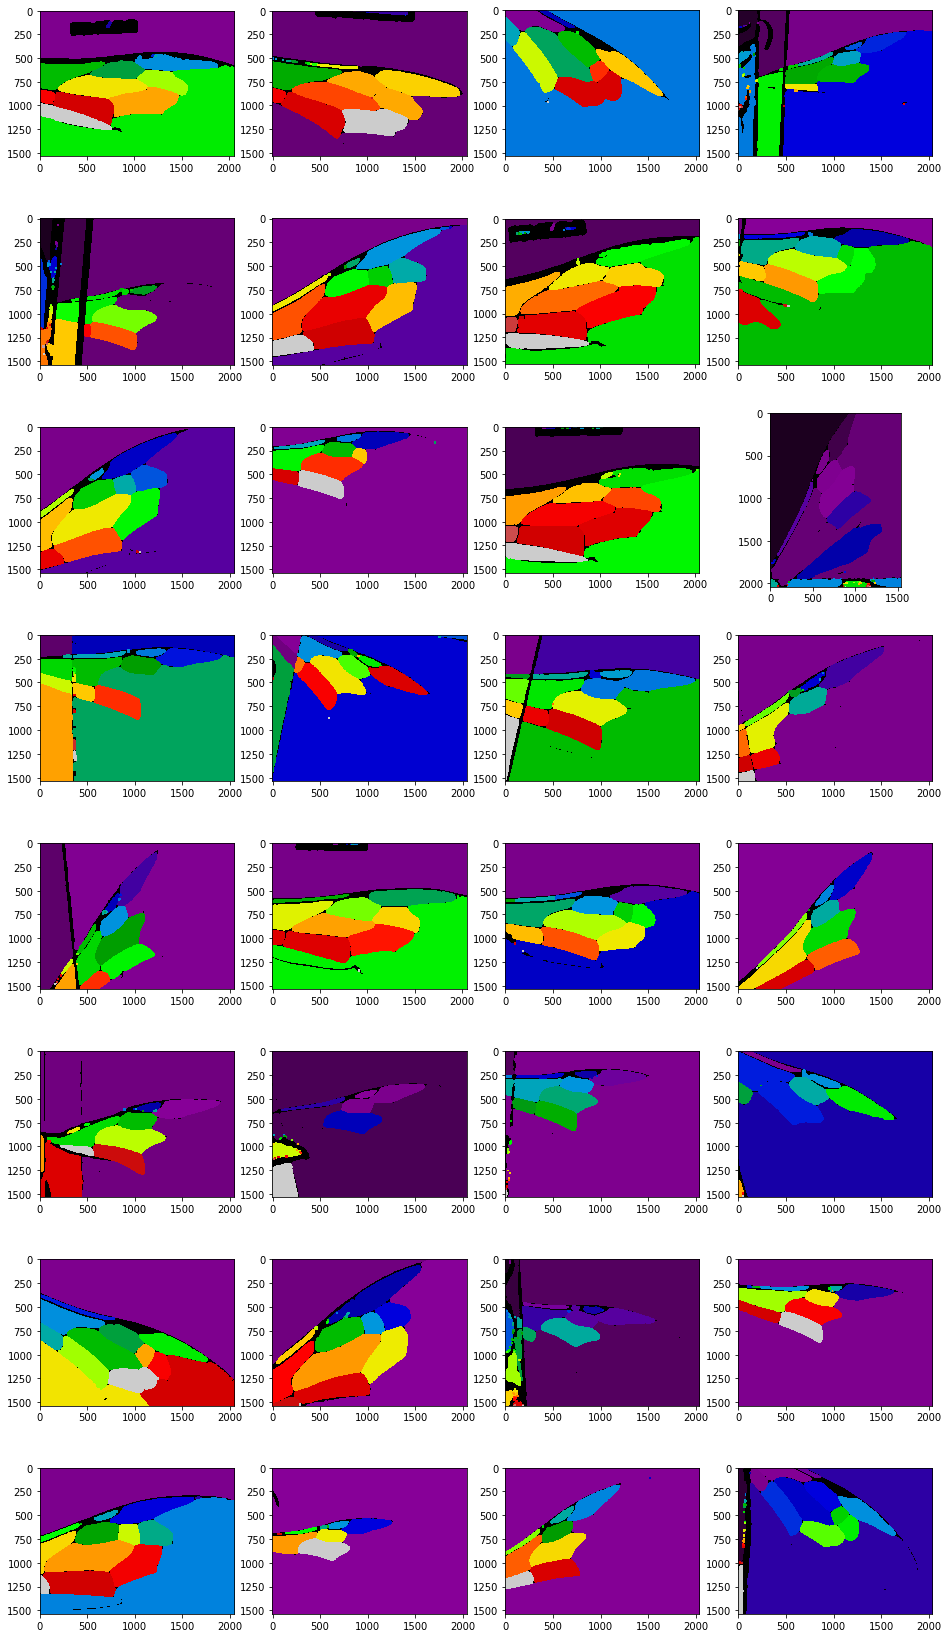

In [83]:
fig=plt.figure(figsize=(16, 30))
for i in range (0, 32):
    img = train_imgs[i].copy()
    ws = process(img)
    fig.add_subplot(8, 4, i+1)
    plt.imshow(ws, cmap='nipy_spectral')
plt.show()

# Intersections Detection

In [84]:
def intersect(img):
    #fig=plt.figure(figsize=(18, 18))

    height, width = img.shape
    step = 60
    intersects = np.full(img.shape, 0)
    for i in range(0, height-step, step//2):
        for j in range(0, width-step, step//2):
            
            colors = set()
            for k in range(i, i+step):
                for l in range(j, j+step):
                    pixel = img[k][l]
                    if pixel != -1 and pixel not in colors:
                        colors.add(pixel)
            if len(colors) >= 4:
                intersects[i+step//2][j+step//2] = 1
                
                
    # mean
    step = 80
    res = set() # set of tuple
    intersects2 = np.full(img.shape, 0)
    for i in range(0, height-step, step):
        for j in range(0, width-step, step):
            pts = []
            for k in range(i, i+step):
                for l in range(j, j+step):
                    if intersects[k][l] != 0:
                        pts.append((k, l))
            if len(pts) >= 2:
                sum_x = 0
                sum_y = 0
                for point in pts:
                    sum_y += point[0]
                    sum_x += point[1]
                mean = (sum_y // len(pts), sum_x // len(pts))
                intersects2[mean[0]][mean[1]] = 1
                res.add(mean)
            else:
                for point in pts:
                    intersects2[point[0]][point[1]] = 255
                    res.add(point)

    #fig.add_subplot(2, 1, 1)
    #plt.imshow(draw_points(img, res))         
    
    # mean
    step = 100
    res = set() # set of tuple
    intersects3 = np.full(img.shape, 0)
    for i in range(0, height-step, step):
        for j in range(0, width-step, step):
            
            # print grid
            for i2 in range(0, 5):
                for j2 in range(0, 5):
                    img[i + i2][j + j2] = 255
            
            pts = []
            for k in range(i, i+step):
                for l in range(j, j+step):
                    if intersects2[k][l] != 0:
                        pts.append((k, l))
            if len(pts) >= 2:
                sum_x = 0
                sum_y = 0
                for point in pts:
                    sum_y += point[0]
                    sum_x += point[1]
                mean = (sum_y // len(pts), sum_x // len(pts))
                intersects3[mean[0]][mean[1]] = 1
                res.add(mean)
            else:
                for point in pts:
                    intersects3[point[0]][point[1]] = 1
                    res.add(point)
                 
   
    #fig.add_subplot(2, 1, 2)
    #plt.imshow(draw_points(img, res))
    #plt.show()
    

    step = 85
    res = set() # set of tuple
    for i in range(0, height-step, step):
        for j in range(0, width-step, step):
            pts = []
            for k in range(i, i+step):
                for l in range(j, j+step):
                    if intersects3[k][l] != 0:
                        pts.append((k, l))
            if len(pts) >= 2:
                sum_x = 0
                sum_y = 0
                for point in pts:
                    sum_y += point[0]
                    sum_x += point[1]
                res.add((sum_y // len(pts), sum_x // len(pts)))
            else:
                for point in pts:
                    res.add(point)
    return res

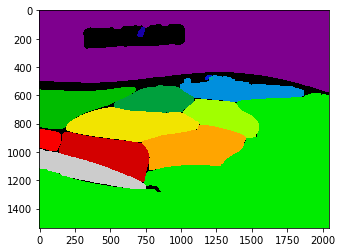

In [85]:
img = train_imgs[0].copy()
ws = process(img)
plt.imshow(ws, cmap='nipy_spectral')

In [90]:
points = intersect(ws)

KeyboardInterrupt: 

In [ ]:
fig=plt.figure(figsize=(10, 10))

fig.add_subplot(1, 2, 1)
plt.imshow(draw_points(ws, points), cmap='nipy_spectral')

fig.add_subplot(1, 2, 2)
plt.imshow(draw_points(img, points))

plt.show()

# Detection on train images

KeyboardInterrupt: 

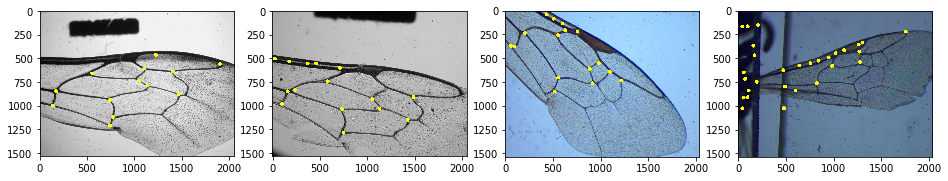

In [88]:
fig=plt.figure(figsize=(16, 30))
for i in range (0, 32):
    img = train_imgs[i].copy()
    ws = process(img)
    points = intersect(ws)
    fig.add_subplot(8, 4, i+1)
    plt.imshow(draw_points(img, points))
plt.show()


# Detection on test image

In [ ]:
test_img = imageio.imread('../TEST/01_inf.jpg')
test_points = np.genfromtxt('../TEST/01_inf.csv', delimiter=',')
ws = process(test_img)
points = intersect(ws)

In [ ]:
fig=plt.figure(figsize=(10, 10))

fig.add_subplot(1, 2, 1)
plt.imshow(draw_points(test_img, test_points), cmap='nipy_spectral')

fig.add_subplot(1, 2, 2)
plt.imshow(draw_points(test_img, points))

plt.show()

# Compute score

In [ ]:
train_labels = np.array([np.array(np.genfromtxt(filename, delimiter=',')) for filename in sorted(glob.glob('../TRAIN/*.csv'))])

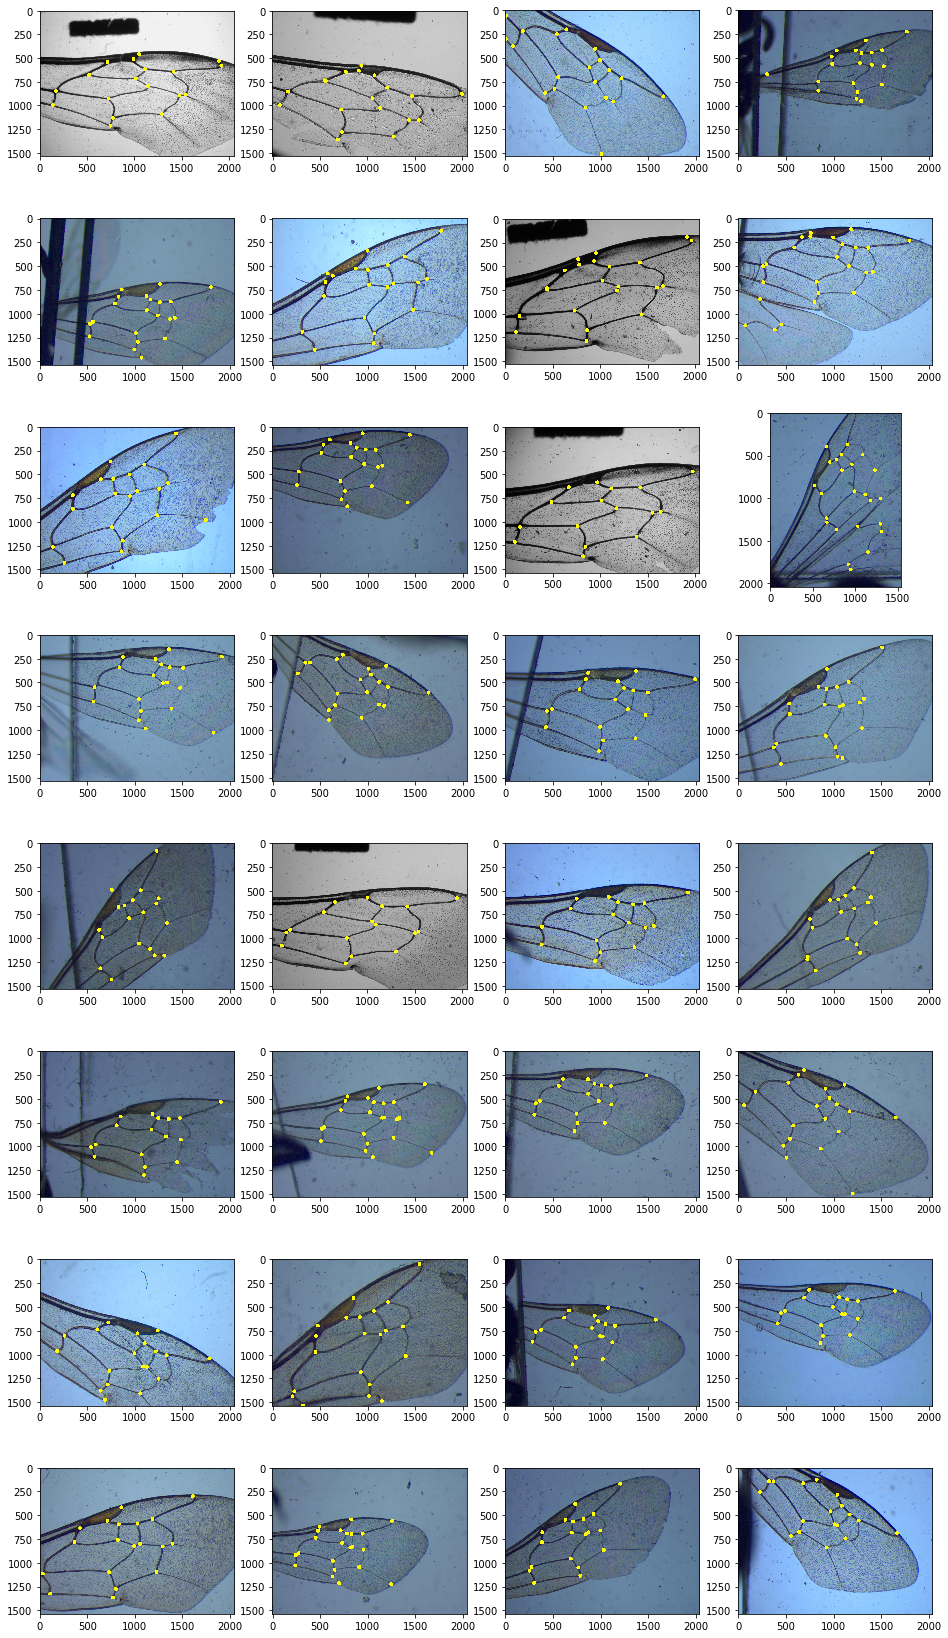

In [76]:
fig=plt.figure(figsize=(16, 30))
for i in range(0, len(train_imgs)):
    fig.add_subplot(8, 4, i+1)
    plt.imshow(draw_points(train_imgs[i], train_labels[i]))

In [77]:
def compute_score(data_x, labels):
    preds = data_x.copy()
    good = set()
    for label in labels:
        for pred in preds:
            if label[0] > pred[0] - 30 and label[0] < pred[0] + 30 and label[1] > pred[1] - 30 and label[1] < pred[1] + 30:
                # pred is correct
                good.add(pred)
                preds.remove(pred)
                break
    precision = len(good) / len(data_x)
    recall = len(good) / len(labels)
    f1 = 2.0 * precision * recall / (precision + recall)
    return precision, recall, f1

In [78]:
def compute_score_total(imgs, labels):
    precision = 0.0
    recall = 0.0
    f1 = 0.0
    for i in range (0, len(imgs)):
        img = imgs[i].copy()
        ws = process(img)
        points = intersect(ws)
        p, r, f = compute_score(points, labels[i])
        precision += p
        recall += r
        f1 += f
        print(round(p,2), round(r,2), round(f,2), '  |  ', end='')
    print('\nprecision : ', precision / len(imgs))
    print('recall : ', recall / len(imgs))    
    print('F1 score : ', f1 / len(imgs))

In [58]:
compute_score_total(train_imgs, train_labels)

0.57 0.57 0.57   |  0.65 0.81 0.72   |  0.6 0.47 0.53   |  0.74 0.64 0.68   |  0.41 0.41 0.41   |  0.38 0.47 0.42   |  0.77 0.56 0.65   |  0.35 0.3 0.32   |  0.42 0.23 0.29   |  0.43 0.35 0.39   |  0.36 0.17 0.24   |  0.35 0.39 0.37   |  0.62 0.42 0.5   |  0.31 0.2 0.24   |  0.67 0.76 0.71   |  0.6 0.47 0.53   |  0.69 0.43 0.53   |  0.22 0.21 0.21   |  0.7 0.74 0.72   |  0.67 0.59 0.62   |  0.16 0.21 0.18   |  0.69 0.55 0.61   |  0.69 0.44 0.54   |  0.05 0.06 0.05   |  0.24 0.35 0.29   |  0.6 0.63 0.62   |  0.29 0.24 0.26   |  0.18 0.24 0.2   |  0.71 0.75 0.73   |  0.33 0.35 0.34   |  0.32 0.32 0.32   |  0.45 0.5 0.47   |  
precision :  0.4752574805020449
recall :  0.4320760393406547
F1 score :  0.4460757678669936
